# Data preprocessing: windows + scaling + split

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler

## Load + visualize data

In [2]:
data_path = "../data/simulation.csv"
df = pd.read_csv(data_path)
df.head()

,t,x,x_clean,v,a,F,label
0,0.000,-0.019806,-0.019806,0.000788,0.034445,0.024836,0
1,0.001,-0.010550,-0.010550,0.005654,-0.008137,-0.004400,0
2,0.002,-0.005870,-0.005870,0.003431,0.031584,0.037411,0
3,0.003,0.001497,0.001497,-0.012721,0.092937,0.083691,0
4,0.004,0.010242,0.010242,-0.001721,-0.029184,-0.001655,0


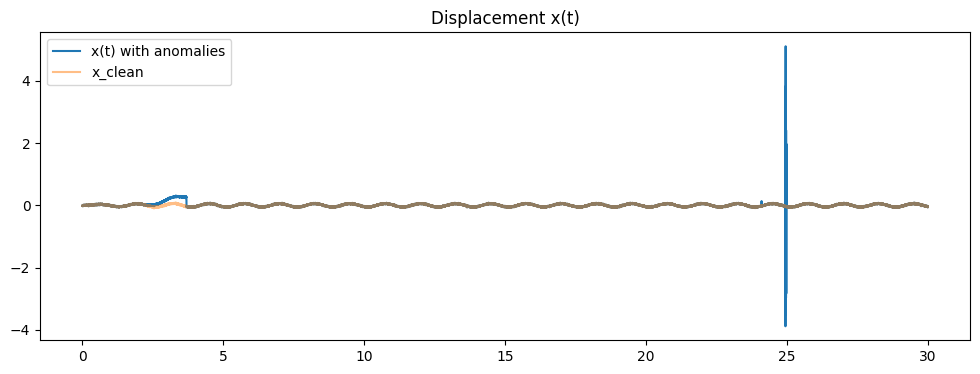

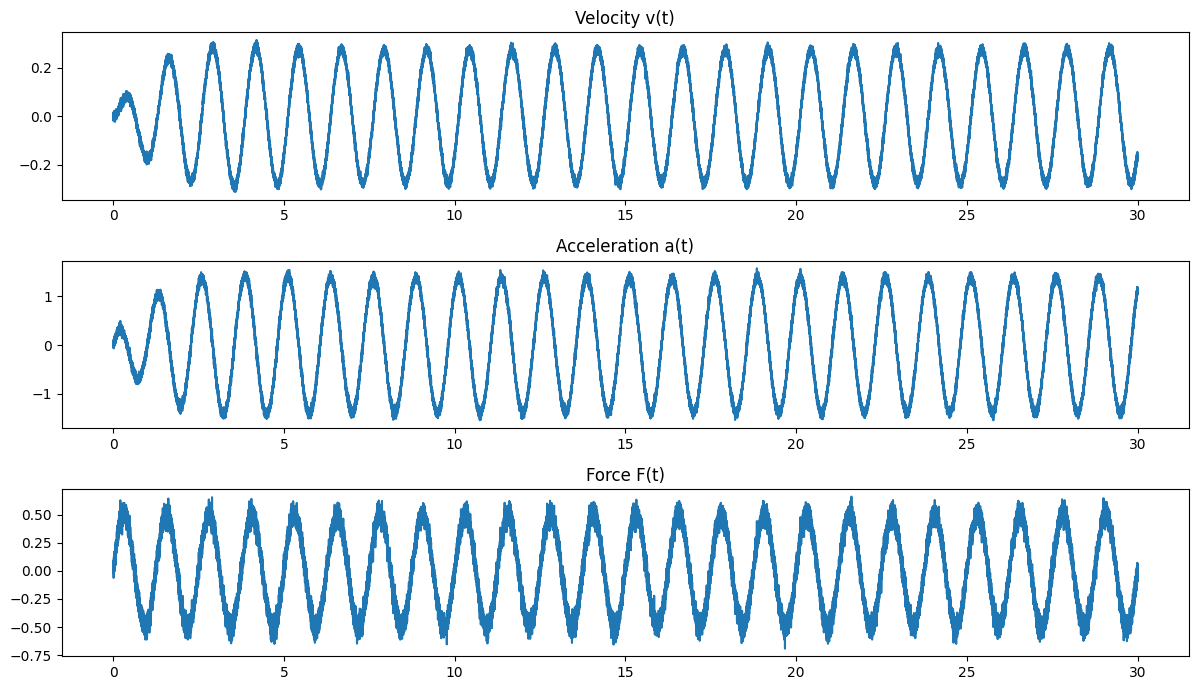

In [3]:
# Displacement with anomalies
plt.figure(figsize=(12,4))
plt.plot(df["t"], df["x"], label="x(t) with anomalies")
plt.plot(df["t"], df["x_clean"], label="x_clean", alpha=0.5)
plt.title("Displacement x(t)")
plt.legend()
plt.show()

# v, a, F
plt.figure(figsize=(12,7))
plt.subplot(3,1,1)
plt.plot(df["t"], df["v"])
plt.title("Velocity v(t)")

plt.subplot(3,1,2)
plt.plot(df["t"], df["a"])
plt.title("Acceleration a(t)")

plt.subplot(3,1,3)
plt.plot(df["t"], df["F"])
plt.title("Force F(t)")

plt.tight_layout()
plt.show()

In [4]:
# Prepare for windowing
features = ["x", "v", "a", "F"]
X = df[features].values
y = df["label"].values

## Window data

In [5]:
WINDOW = 128
STEP = 16

def create_windows(X, y, window=128, step=16):
    Xw, yw = [], []
    for start in range(0, len(X) - window, step):
        end = start + window
        Xw.append(X[start:end])
        # Window is anomalous if ANY point inside is anomalous
        yw.append(1 if np.any(y[start:end] == 1) else 0)
    return np.array(Xw), np.array(yw)

Xw, yw = create_windows(X, y, WINDOW, STEP)
Xw.shape, yw.shape

((1867, 128, 4), (1867,))

In [6]:
# Separate normal and anomalous windows

normal_idx = np.where(yw == 0)[0]
anom_idx = np.where(yw == 1)[0]

Xw_normal = Xw[normal_idx]
Xw_anom = Xw[anom_idx]

print("Normal windows:", len(Xw_normal))
print("Anomalous windows:", len(Xw_anom))

Normal windows: 1747
Anomalous windows: 120


## Split

In [7]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Train
N = len(Xw_normal)
N_train = int(N * train_ratio)

X_train = Xw_normal[:N_train]
y_train = np.zeros(len(X_train))

# Val/test
remaining_normal = Xw_normal[N_train:]
N_rem = len(remaining_normal)

N_val_normal = int(N_rem * (val_ratio / (val_ratio + test_ratio)))

X_val_normal = remaining_normal[:N_val_normal]
X_test_normal = remaining_normal[N_val_normal:]

# SPlit anomalous windows evenly
A = len(Xw_anom)
A_val = A // 2
A_test = A - A_val

X_val_anom = Xw_anom[:A_val]
X_test_anom = Xw_anom[A_val:]

y_val_normal = np.zeros(len(X_val_normal))
y_val_anom = np.ones(len(X_val_anom))

y_test_normal = np.zeros(len(X_test_normal))
y_test_anom = np.ones(len(X_test_anom))

# Combine val and test
X_val = np.concatenate([X_val_normal, X_val_anom], axis=0)
y_val = np.concatenate([y_val_normal, y_val_anom], axis=0)

X_test = np.concatenate([X_test_normal, X_test_anom], axis=0)
y_test = np.concatenate([y_test_normal, y_test_anom], axis=0)

## Scale

In [8]:
scaler = StandardScaler()

# Fit only on training data
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(X_train_reshaped)

def scale_windows(X, scaler):
    W, T, F = X.shape
    XS = X.reshape(-1, F)
    XS = scaler.transform(XS)
    return XS.reshape(W, T, F)

X_train_scaled = scale_windows(X_train, scaler)
X_val_scaled = scale_windows(X_val, scaler)
X_test_scaled = scale_windows(X_test, scaler)

## Print mean/std after scaling and save splis

In [9]:
print("TRAIN mean:", X_train_scaled.mean(axis=(0,1)))
print("TRAIN std:", X_train_scaled.std(axis=(0,1)))

print("\nVAL mean:", X_val_scaled.mean(axis=(0,1)))
print("VAL std:", X_val_scaled.std(axis=(0,1)))

print("\nTEST mean:", X_test_scaled.mean(axis=(0,1)))
print("TEST std:", X_test_scaled.std(axis=(0,1)))

TRAIN mean: [-1.33428343e-15 -2.17411105e-15  1.92283167e-16 -1.18423091e-16]
TRAIN std: [1. 1. 1. 1.]

VAL mean: [0.30207349 0.10051579 0.08893751 0.09581749]
VAL std: [1.38904775 1.03024138 1.0199881  0.99602797]

TEST mean: [ 0.69890748 -0.19413666 -0.05935544 -0.19678686]
TEST std: [5.41751902 1.03621492 1.01586429 0.993477  ]


In [10]:
out_dir = "../data/splits"
os.makedirs(out_dir, exist_ok=True)

np.save(os.path.join(out_dir, "X_train.npy"), X_train_scaled)
np.save(os.path.join(out_dir, "y_train.npy"), y_train)

np.save(os.path.join(out_dir, "X_val.npy"), X_val_scaled)
np.save(os.path.join(out_dir, "y_val.npy"), y_val)

np.save(os.path.join(out_dir, "X_test.npy"), X_test_scaled)
np.save(os.path.join(out_dir, "y_test.npy"), y_test)

print("Saved train/val/test splits to ../data/splits")

Saved train/val/test splits to ../data/splits
